# **Première partie: TF-IDF**

##Chargement des données

In [14]:
from datasets import load_dataset
ds = load_dataset("tblard/allocine")

In [15]:
import pandas as pd
# convertir chaque split en Dataframe pandas
df_train = ds["train"].to_pandas()
df_valid = ds["validation"].to_pandas()
df_test  = ds["test"].to_pandas()

In [16]:
print(f'la  taille des donnés entrainement : {df_train.shape}')
print(f'la  taille des donnés test : {df_test.shape}')
print(f'la  taille des donnés validation : {df_test.shape}')

la  taille des donnés entrainement : (160000, 2)
la  taille des donnés test : (20000, 2)
la  taille des donnés validation : (20000, 2)


## Structuration des données

In [17]:
# Le dataset a généralement: 'review' (texte) et 'label' (0=neg, 1=pos)
df_train = df_train.rename(columns={"review": "text", "label": "label"})
df_valid = df_valid.rename(columns={"review": "text", "label": "label"})
df_test  = df_test.rename(columns={"review": "text", "label": "label"})

In [18]:
# Mapper les labels en texte
label_map = {0: "negative", 1: "positive"}
for df in (df_train, df_valid, df_test):
    df["label_text"] = df["label"].map(label_map)

In [19]:
# concaténer les 3 dataframes
df_all = pd.concat(
    [df_train.assign(split="train"),
     df_valid.assign(split="validation"),
     df_test.assign(split="test")],
    ignore_index=True
)
print(len(df_all))

200000


In [20]:
# Visualiser les données
print(df_train.head(10))

                                                text  label label_text
0  Si vous cherchez du cinéma abrutissant à tous ...      0   negative
1  Trash, re-trash et re-re-trash...! Une horreur...      0   negative
2  Et si, dans les 5 premières minutes du film, l...      0   negative
3  Mon dieu ! Quelle métaphore filée ! Je suis ab...      0   negative
4  Premier film de la saga Kozure Okami, "Le Sabr...      1   positive
5  L'amnésie est un thème en or pour susciter le ...      0   negative
6  Tout commence comme une comédie légère avant u...      1   positive
7  un excellent film qui merite ses quatre étoile...      1   positive
8  Deuxième long métrage de Pasolini, Mamma Roma ...      1   positive
9  Créateur de la célèbre série télévisée Kaamelo...      0   negative


In [21]:
# valeurs manquantes
print("Le nombre de labels manquants est :", df_train["label"].isna().sum())

Le nombre de labels manquants est : 0


In [22]:
print("Le nombre de lignes dupliquées est :", df_train.duplicated(subset=["label", "text"]).sum())

Le nombre de lignes dupliquées est : 534


In [23]:
# Supprimer les doublons
df_train = df_train.drop_duplicates(subset="text").reset_index(drop=True)
print(len(df_train))

159461


In [24]:
print("\nRépartition labels (train):")
print(df_train["label"].value_counts(dropna=False))
print("\nTaille des splits:", len(df_train), len(df_valid), len(df_test))


Répartition labels (train):
label
1    80334
0    79127
Name: count, dtype: int64

Taille des splits: 159461 20000 20000


--> On remarque que les données sont plus au moins équilibrées au niveau des labels

## Evaluation of models

In [32]:
#imports
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [33]:
def evaluate_and_report(y_true, y_pred, title=""):
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    p   = precision_score(y_true, y_pred)
    r   = recall_score(y_true, y_pred)
    print(f"\n=== {title} ===")
    print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | Precision: {p:.4f} | Recall: {r:.4f}")
    print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))
    return {"model": title, "accuracy": acc, "f1": f1, "precision": p, "recall": r}

In [34]:
def plot_confusion(y_true, y_pred, labels=("neg","pos"), title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    fig, ax = plt.subplots(figsize=(4.5,4))
    im = ax.imshow(cm, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           ylabel="Vrai", xlabel="Prédit", title=title)
    # Annot
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()


## Modèles de machine learning

1) Logistic Regression

In [35]:
pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        strip_accents="unicode",
        ngram_range=(1,2),  # unigram+bigram
        min_df=2,
        max_df=0.98,
        sublinear_tf=True
    )),
    ("clf", LogisticRegression(max_iter=200, C=2.0, n_jobs=None))
])

# pipe_lr.fit(df_train["text"], df_train["label"])
# pred_lr = pipe_lr.predict(df_test["text"])
# res_lr = evaluate_and_report(df_test["label"], pred_lr, title="TF-IDF + LogisticRegression")
# # plot_confusion(df_test["label"], pred_lr, title="CM - TFIDF+LR")

In [36]:
pipe_lr

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.98, min_df=2, ngram_range=(1, 2),
                                 strip_accents='unicode', sublinear_tf=True)),
                ('clf', LogisticRegression(C=2.0, max_iter=200))])

Le modèle Logistic Regression donne de bonnes perforamnaces en termes d'accuracy, de recall et de precision.

2) Logistic Regression (régularisation = Ridge)

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        strip_accents="unicode",
        ngram_range=(1, 2),   # uni + bi-grammes
        min_df=2,
        max_df=0.95,          # un peu plus strict que 0.98
        sublinear_tf=True,    # tf = 1 + log(tf)
        norm="l2"
    )),
    ("clf", LogisticRegression(
        solver="liblinear",   # solide pour texte binaire
        penalty="l2",
        C=2.0,                # régularisation un peu plus souple
        class_weight="balanced",  # retire si classes parfaitement équilibrées
        max_iter=5000,
        n_jobs=-1             # utilisé par liblinear si multiclasses
    ))
])

pipe_lr.fit(df_train["text"], df_train["label"])
pred_lr = pipe_lr.predict(df_test["text"])
res_lr = evaluate_and_report(df_test["label"], pred_lr, title="TF-IDF + LogisticRegression (tuned defaults)")
# plot_confusion(df_test["label"], pred_lr, title="CM - TFIDF+LR (tuned)")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(



=== TF-IDF + LogisticRegression (tuned defaults) ===
Accuracy: 0.9433 | F1: 0.9411 | Precision: 0.9379 | Recall: 0.9443

Classification report:
               precision    recall  f1-score   support

           0     0.9484    0.9424    0.9453     10408
           1     0.9379    0.9443    0.9411      9592

    accuracy                         0.9433     20000
   macro avg     0.9431    0.9433    0.9432     20000
weighted avg     0.9433    0.9433    0.9433     20000



Les résultats de la régularisation Ridge est légèrement meilleures.

3. Logistic Regression (régularisation = Lasso)

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        strip_accents="unicode",
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True,
        norm="l2"
    )),
    ("clf", LogisticRegression(
        solver="liblinear",   # requis pour L1 (ou 'saga')
        penalty="l1",         # ✅ LASSO
        C=2.0,
        class_weight="balanced",  # enlève si classes équilibrées
        max_iter=5000,
        n_jobs=-1
    ))
])

pipe_lr.fit(df_train["text"], df_train["label"])
pred_lr = pipe_lr.predict(df_test["text"])
res_lr = evaluate_and_report(df_test["label"], pred_lr, title="TF-IDF + LogisticRegression (L1 - Lasso)")
# plot_confusion(df_test["label"], pred_lr, title="CM - TFIDF+LR (L1)")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(



=== TF-IDF + LogisticRegression (L1 - Lasso) ===
Accuracy: 0.9413 | F1: 0.9391 | Precision: 0.9352 | Recall: 0.9430

Classification report:
               precision    recall  f1-score   support

           0     0.9470    0.9398    0.9434     10408
           1     0.9352    0.9430    0.9391      9592

    accuracy                         0.9413     20000
   macro avg     0.9411    0.9414    0.9412     20000
weighted avg     0.9413    0.9413    0.9413     20000



Le modèle Lasso est moins bon que le modèle Ridge

4) SVM

In [ ]:
pipe_svm = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        strip_accents="unicode",
        ngram_range=(1,2),
        min_df=2,
        max_df=0.98,
        sublinear_tf=True
    )),
    ("clf", LinearSVC(C=1.0))
])
pipe_svm.fit(df_train["text"], df_train["label"])
pred_svm = pipe_svm.predict(df_test["text"])
res_svm = evaluate_and_report(df_test["label"], pred_svm, title="TF-IDF + LinearSVM")
# plot_confusion(df_test["label"], pred_svm, title="CM - TFIDF+SVM")

Le modèle SVM est le meilleurs en terme de performance (accuracy + recall + précision)   ✅


5) KNN

In [ ]:
# ================= KNN (TF-IDF + KNeighborsClassifier) =================
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

pipe_knn = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        strip_accents="unicode",
        ngram_range=(1, 2),   # uni + bi-grammes
        min_df=2,
        max_df=0.95,
        sublinear_tf=True,
        norm="l2"
    )),
    ("clf", KNeighborsClassifier(
        n_neighbors=5,        # k de départ (essaie 3/5/7/11)
        metric="cosine",      # distance cosinus (recommandé en texte)
        algorithm="brute",    # nécessaire pour 'cosine'
        weights="distance",   # pondère par la proximité (souvent mieux)
        n_jobs=-1
    ))
])

pipe_knn.fit(df_train["text"], df_train["label"])
pred_knn = pipe_knn.predict(df_test["text"])

# Réutilise tes helpers déjà définis :
res_knn = evaluate_and_report(df_test["label"], pred_knn, title="TF-IDF + KNN (cosine)")
# plot_confusion(df_test["label"], pred_knn, title="CM - TFIDF+KNN")


## Interprétation
KNN (acc ≈ 0,83) est nettement moins bon que tes modèles linéaires (SVM/LR ~0,9–0,95+).

En texte TF-IDF (très haute dimension, très clairsemé), KNN souffre de:
   - temps d'exécution très important

   - malédiction de la dimension → toutes les distances se ressemblent;

   - mauvaise pertinence des distances (si pas cosinus) ;

   - coût d’inférence élevé (comparaison à tous les docs).

## Entrainer le meilleur modèles avec les données train et valid

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# 1) concaténer train + valid
df_tv = pd.concat([df_train, df_valid], ignore_index=True)

# 2) (re)définir ton pipeline SVM
pipe_svm = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True, strip_accents="unicode",
        ngram_range=(1,2), min_df=2, max_df=0.98, sublinear_tf=True
    )),
    ("clf", LinearSVC(C=1.0))
])

# 3) entraîner sur train+valid
pipe_svm.fit(df_tv["text"], df_tv["label"])

# 4) évaluer sur test (non touché)
pred = pipe_svm.predict(df_test["text"])
_ = evaluate_and_report(df_test["label"], pred, title="SVM entraîné sur train+valid (test)")
# plot_confusion(df_test["label"], pred, title="CM - SVM train+valid")


En augmentant la taille des données, on constate que les performances du modèle SVM s'améliorent légèrement.

# Evaluation du modèle SVM avec les courbes ROC et PR

In [ ]:
# imports
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.model_selection import LearningCurveDisplay, StratifiedKFold

In [ ]:
# Courbes PR & ROC
def plot_pr_roc(pipe, X_test, y_test, title_prefix=""):
    # Score = proba (si dispo) sinon decision_function
    if hasattr(pipe, "predict_proba"):
        scores = pipe.predict_proba(X_test)[:,1]
    elif hasattr(pipe, "decision_function"):
        scores = pipe.decision_function(X_test)
    else:
        raise ValueError("Le modèle ne fournit ni predict_proba ni decision_function.")

    # PR
    p, r, _ = precision_recall_curve(y_test, scores)
    ap = average_precision_score(y_test, scores)
    plt.figure(figsize=(5.2,4))
    plt.plot(r, p, linewidth=2)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title_prefix} PR curve (AP={ap:.3f})")
    plt.grid(True); plt.tight_layout(); plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5.2,4))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{title_prefix} ROC curve (AUC={roc_auc:.3f})")
    plt.grid(True); plt.tight_layout(); plt.show()

# Learning curve sur train
def plot_learning_curve(pipe, X_train, y_train, cv_splits=5, title="Learning curve"):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    fig, ax = plt.subplots(figsize=(5.8,4.2))
    LearningCurveDisplay.from_estimator(
        pipe, X_train, y_train, train_sizes=np.linspace(0.1,1.0,5),
        cv=cv, scoring="f1", n_jobs=-1, ax=ax
    )
    ax.set_title(title)
    plt.tight_layout(); plt.show()


In [ ]:
# 1) Métriques + CM
y_te = df_test["label"].astype(int).values
y_pred = pipe_svm.predict(df_test["text"])
evaluate_and_report(y_te, y_pred, title="Best model (TEST)")
plot_confusion(y_te, y_pred, title="CM - Best model (TEST)")

# 2) Courbes PR & ROC (pour LR; pour SVM on utilise decision_function)
plot_pr_roc(pipe_svm, df_test["text"], y_te, title_prefix="Best model")

# 3) Courbe d’apprentissage (sur le train)
plot_learning_curve(pipe_svm, df_train["text"], df_train["label"].astype(int).values,
                    cv_splits=5, title="Learning curve (F1)")

## Interprétation

- AP = 0,986 (courbe PR) : sur une base (quasi) équilibrée, le hasard donnerait ~0,50. Ici, le modèle garde une précision ~1.0 presque tout le long, et ne chute qu’en poussant le rappel vers 1.0 (zone où on accepte beaucoup de faux positifs).

- ROC AUC = 0,987 : en tirant au hasard un positif et un négatif, le SVM classe le positif au-dessus ~98,7% du temps. C’est un pouvoir de séparation très élevé.

--> à ces niveaux AP/ROC-AUC ~ 0,99, le modèle SVM est très performant. Les gains restants viendront surtout du seuil, d’un léger tuning (C, n-grammes, stopwords) et d’une analyse d’erreurs ciblée.

- Learning curve est bonne puisque les performances des données de test est bonne et la différence entre la performance de l'nsemble test et train est très proche

#**Deuxième partie: RNN avec embedings**

In [92]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name="Modèle"):
    """
    Affiche les courbes de loss et d'accuracy pour un entraînement Keras.

    Args:
        history: objet History retourné par model.fit()
        model_name: nom du modèle (string), affiché dans le titre
    """
    history_dict = history.history

    plt.figure(figsize=(12,5))

    # Courbe de loss
    plt.subplot(1,2,1)
    plt.plot(history_dict['loss'], label='Entraînement')
    plt.plot(history_dict['val_loss'], label='Validation')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Épochs')
    plt.ylabel('Binary Crossentropy')
    plt.legend()

    # Courbe d'accuracy
    plt.subplot(1,2,2)
    plt.plot(history_dict['accuracy'], label='Entraînement')
    plt.plot(history_dict['val_accuracy'], label='Validation')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Épochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [40]:
# imports
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

##Tokenisation
On effectue la tokenisation pour les 3 dataframes: train, test et validation.

In [41]:
#  Tokenisation et  padding
vocab_size = 20000
max_len = 150
embedding_dim = 128

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['text'])

X_train = tokenizer.texts_to_sequences(df_train['text'])
X_train = pad_sequences(X_train, maxlen=max_len, padding="post", truncating="post")

X_test = tokenizer.texts_to_sequences(df_test['text'])
X_test = pad_sequences(X_test, maxlen=max_len, padding="post", truncating="post")

X_val = tokenizer.texts_to_sequences(df_valid['text'])
X_val = pad_sequences(X_val, maxlen=max_len, padding="post", truncating="post")


y_val= np.array(df_valid['label'])
y_train = np.array(df_train['label'])
y_test = np.array(df_test['label'])

num_words = len(tokenizer.word_index) + 1


## Pour contruire notre modèle de classification , on prendra en compte 2 types d'embeddings


1.   Embedding pendant l'entrainement
2.   Embedding préentrainer
    





##**1.**   **Embedding pendant l'entrainement**

In [78]:

model_1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model_1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_1.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [79]:

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,   # arrête si pas d’amélioration pendant 3 epochs
    restore_best_weights=True
)
history_1 = model_1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[early_stop],
    batch_size=128,
    verbose=1
)

Epoch 1/50
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.5549 - loss: 0.6737 - val_accuracy: 0.9007 - val_loss: 0.2658
Epoch 2/50
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.9140 - loss: 0.2240 - val_accuracy: 0.9243 - val_loss: 0.1898
Epoch 3/50
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.9501 - loss: 0.1372 - val_accuracy: 0.9299 - val_loss: 0.1828
Epoch 4/50
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.9668 - loss: 0.0974 - val_accuracy: 0.9278 - val_loss: 0.2070
Epoch 5/50
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.9780 - loss: 0.0679 - val_accuracy: 0.9225 - val_loss: 0.2348
Epoch 6/50
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.9856 - loss: 0.0472 - val_accuracy: 0.9230 - val_loss: 0.2829


###Evaluation d'un modèle et entrainement

In [88]:
#évaluation
loss, acc = model_1.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy sur test : {acc:.2f}")

Accuracy sur test : 0.93


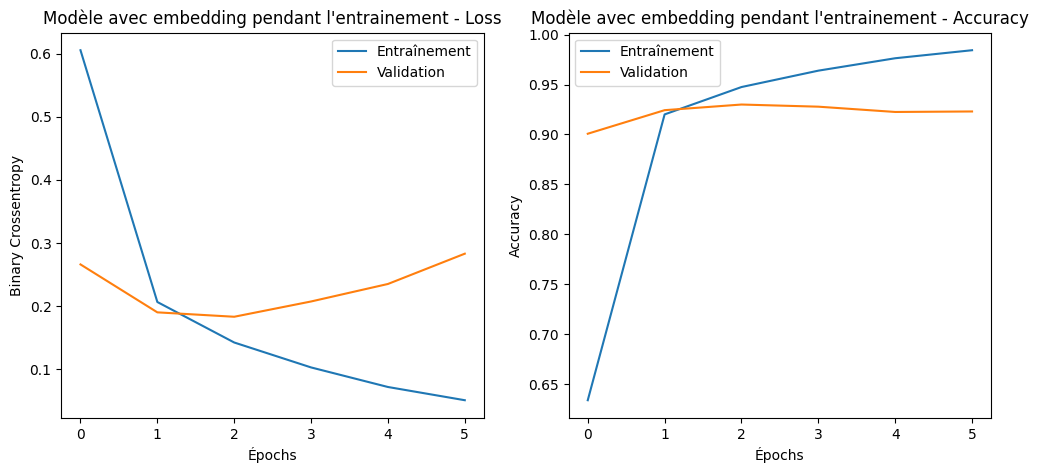

In [93]:
plot_training_history(history_1, model_name="Modèle avec embedding pendant l'entrainement")

In [89]:
#exemple d'inférence
new_text = ["Ce film est génial, un chef d'oeuvre incroyable !"]
seq = tokenizer.texts_to_sequences(new_text)
padded_seq = pad_sequences(seq, maxlen=max_len, padding="post")

prediction = model_1.predict(padded_seq)
print("Probabilité positif :", prediction[0][0])
print("Classe prédite :", int(prediction[0][0] > 0.5))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Probabilité positif : 0.9960425
Classe prédite : 1


##**2. Embedding préentrainer avec "fastText facebook 2016"**



In [ ]:
# pip install --upgrade tensorflow

In [82]:
pip install gensim

In [100]:
import gensim.downloader as api

# Charger FastText français
ft_model = api.load("fasttext-wiki-news-subwords-300")  # vecteurs 300d

embedding_dim = 300
num_words = min(vocab_size, len(tokenizer.word_index) + 1)

# Créer la matrice d'embedding
embedding_matrix_FastText = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    if word in ft_model:
        embedding_matrix_FastText[i] = ft_model[word]
    else:
        embedding_matrix_FastText[i] = np.random.normal(size=(embedding_dim,))


In [101]:
# Construire le modèle


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,   # arrête si pas d’amélioration pendant 3 epochs
    restore_best_weights=True
)

model_fasText = Sequential([
    Embedding(input_dim=num_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix_FastText],
              input_length=max_len,
              trainable=False),
    LSTM(128),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_fasText.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_fasText.summary()

# Entraînement
history_2=model_fasText.fit(X_train, y_train, validation_data=(X_val, y_val),callbacks=[early_stop], epochs=50, batch_size=128)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,000,000 (22.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,000,000 (22.89 MB)

Epoch 1/50
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.5154 - loss: 0.6923 - val_accuracy: 0.5346 - val_loss: 0.6907
Epoch 2/50
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5201 - loss: 0.6898 - val_accuracy: 0.5468 - val_loss: 0.6850
Epoch 3/50
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5465 - loss: 0.6848 - val_accuracy: 0.5368 - val_loss: 0.6883
Epoch 4/50
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5440 - loss: 0.6841 - val_accuracy: 0.4959 - val_loss: 0.6899
Epoch 5/50
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5236 - loss: 0.6870 - val_accuracy: 0.6721 - val_loss: 0.6281
Epoch 6/50
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.6024 - loss: 0.6501 - val_accuracy: 0.8008 - val_loss: 0.4296
Epoch 7/50
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.8165 - loss: 0.4069 - val_accuracy: 0.8406 - val_loss: 0.3648
Epoch 8/50
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.8603 -

## Evaluation du modèle et inférence

In [102]:
#évaluation
loss, acc = model_fasText.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy sur test : {acc:.2f}")

Accuracy sur test : 0.87


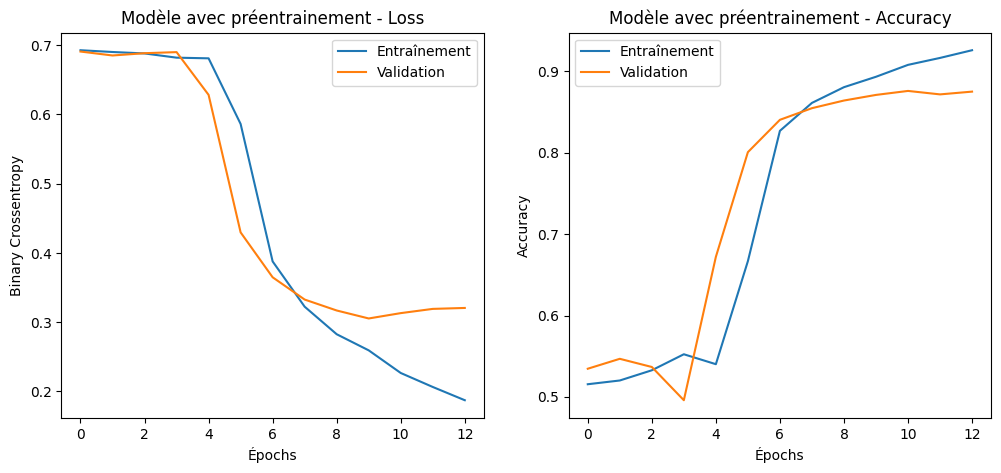

In [103]:
plot_training_history(history_2, model_name="Modèle avec préentrainement")

In [91]:
#exemple d'inférence
new_text = ["Ce film est génial, un chef d'oeuvre incroyable !"]
seq = tokenizer.texts_to_sequences(new_text)
padded_seq = pad_sequences(seq, maxlen=max_len, padding="post")
prediction = model_fasText.predict(padded_seq)
print("Probabilité positif :", prediction[0][0])
print("Classe prédite :", int(prediction[0][0] > 0.5))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Probabilité positif : 0.9969208
Classe prédite : 1


#**CONCLUSION:**
**Le modèle qui utilise un embedding pendant l'entrainement est nettement mieux que celui préentrainer**

#**Troisième partie : Ajout de la couche d'attention Bahdanau**

## 1. Ajout de la couche aux modèle avec embedding pendant l'entrainement

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, Layer
import tensorflow.keras.backend as K




class BahdanauAttention(Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)  # pour hidden states
        self.W2 = tf.keras.layers.Dense(units)  # pour query
        self.V = tf.keras.layers.Dense(1)       # pour score

    def call(self, values, query):
        """
        values : sortie du LSTM, shape = (batch_size, time_steps, hidden_size)
        query : état final du LSTM, shape = (batch_size, hidden_size)
        """
        # ajouter une dimension pour le query pour broadcast
        query_with_time_axis = tf.expand_dims(query, 1)  # shape = (batch_size, 1, hidden_size)

        # calcul du score
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(query_with_time_axis)))
        # shape = (batch_size, time_steps, 1)

        # softmax sur le temps
        attention_weights = tf.nn.softmax(score, axis=1)  # shape = (batch_size, time_steps, 1)

        # pondération des valeurs
        context_vector = attention_weights * values  # shape = (batch_size, time_steps, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # somme pondérée -> (batch_size, hidden_size)

        return context_vector, attention_weights


In [66]:

# modèle avec embedding pendant l'entrainement avec couche attention

from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense
from tensorflow.keras.models import Model

# Définir l'entrée
inputs = Input(shape=(max_len,))
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs)

# LSTM avec return_sequences=True pour l'attention et return_state=True pour récupérer l'état final
lstm_out, state_h, state_c = LSTM(128, return_sequences=True, return_state=True)(embedding)

# Couche Bahdanau attention (query = état final du LSTM)
attention_layer = BahdanauAttention(units=128)
att_out, att_weights = attention_layer(lstm_out, state_h)

# Dropout et Dense final
drop = Dropout(0.3)(att_out)
outputs = Dense(1, activation='sigmoid')(drop)

# Création du modèle
model_bahdanau_1 = Model(inputs, outputs)

# Compilation
model_bahdanau_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bahdanau_1.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 150, 300)  │  6,000,000 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 150,      │    219,648 │ embedding_5[0][0] │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention… │ [(None, 128),     │     33,153 │ lstm_7[0][0],     │
│ (BahdanauAttention) │ (None, 150, 1)]   │            │ lstm_7[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ bahdanau_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 1)         │        129 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,252,930 (23.85 MB)

 Trainable params: 6,252,930 (23.85 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,   # arrête si pas d’amélioration pendant 3 epochs
    restore_best_weights=True
)

In [105]:
history_bahdanau_1 = model_bahdanau_1.fit(
    X_train, y_train,
    callbacks=[early_stop],
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=128
)


Epoch 1/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.9896 - loss: 0.0322 - val_accuracy: 0.9265 - val_loss: 0.3006
Epoch 2/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.9938 - loss: 0.0213 - val_accuracy: 0.9235 - val_loss: 0.3165
Epoch 3/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.9957 - loss: 0.0145 - val_accuracy: 0.9240 - val_loss: 0.3820
Epoch 4/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.9967 - loss: 0.0111 - val_accuracy: 0.9220 - val_loss: 0.4006


In [106]:
#évaluation
loss, acc = model_bahdanau_1.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy sur test : {acc:.2f}")

Accuracy sur test : 0.93


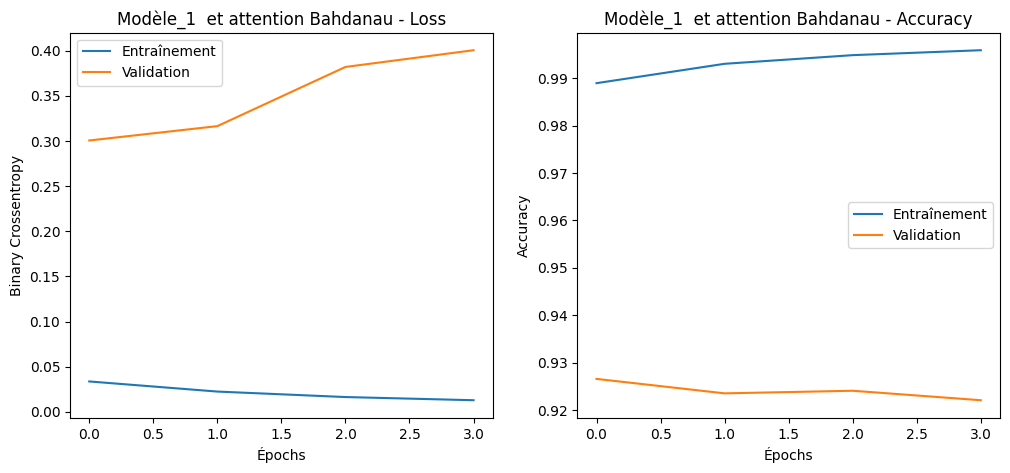

In [107]:
plot_training_history(history_bahdanau_1, model_name="Modèle_1  et attention Bahdanau")

## 2. Ajout de la couche aux modèle préentrainer

In [108]:
lstm_out, state_h, state_c = LSTM(128, return_sequences=True, return_state=True)(embedding)
attention_layer = BahdanauAttention(units=128)
att_out, att_weights = attention_layer(lstm_out, state_h)
drop = Dropout(0.3)(att_out)
outputs = Dense(1, activation='sigmoid')(drop)
model_bahdanau_2 = Model(inputs, outputs)
model_bahdanau_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])




In [109]:
# Entraînement
history_bahdanau_2 = model_bahdanau_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    epochs=20,
    batch_size=128
)

Epoch 1/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.9467 - loss: 0.1340 - val_accuracy: 0.9228 - val_loss: 0.2872
Epoch 2/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.9904 - loss: 0.0296 - val_accuracy: 0.9254 - val_loss: 0.3151
Epoch 3/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.9941 - loss: 0.0195 - val_accuracy: 0.9228 - val_loss: 0.3018
Epoch 4/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.9951 - loss: 0.0162 - val_accuracy: 0.9242 - val_loss: 0.3662


In [110]:
#évaluation
loss, acc = model_bahdanau_2.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy sur test : {acc:.2f}")

Accuracy sur test : 0.93


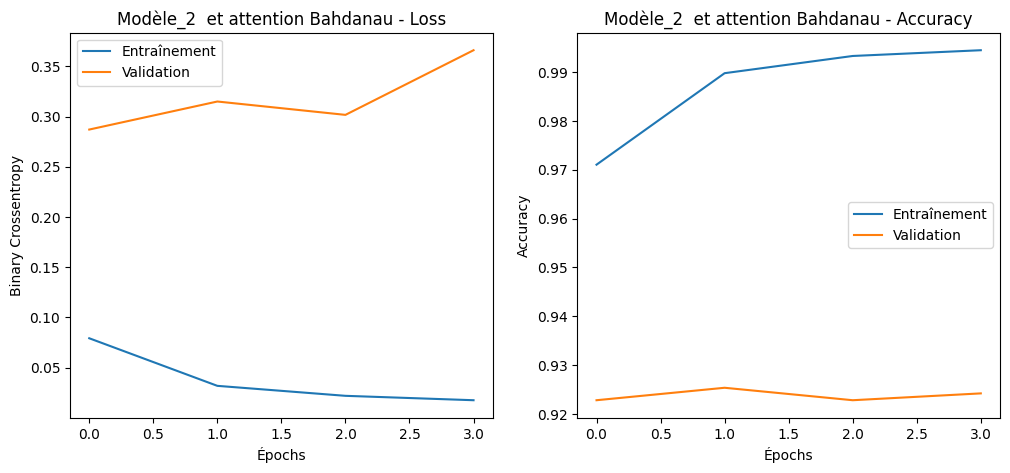

In [111]:
plot_training_history(history_bahdanau_2, model_name="Modèle_2  et attention Bahdanau")

#**On remarque que la couche bahdannou a améliorer le modèle préentrainer et a gardé la même performance pour le modèle avec embedding pendant entrainement**